In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import random_split
import torch.nn.functional as F
#import torch.optim as optim

import pandas as pd
import seaborn as sns
import sys



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/data/marci/mjakowsk/miniconda3/envs/eds4ai/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/data/marci/mjakowsk/miniconda3/envs/eds4ai/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/data/marci/mjakowsk/miniconda3/envs/eds4ai/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/data/marci/mjakowsk/miniconda3/envs/eds4ai/lib/python3.10/site-packages/trait

In [2]:
import torch
torch.cuda.is_available()


False

In [3]:
### Set seed
seed = 43
torch.manual_seed(seed)

# Set Xavier Scaling
xavier_scale = 1

In [4]:
from pathlib import Path
import os

#create trial_name
trial_name = "sd" + str(seed) + '_xs' + str(xavier_scale)
trial_name = trial_name.replace('.', '-')
plot_dir = f"./trials/{trial_name}/plots"

#checkpoint_filename = f"./trials/{trial_name}/checkpoints/bruh.txt"
#os.makedirs(os.path.dirname(checkpoint_filename), exist_ok=True)

#with open(checkpoint_filename, "w") as f:
    #f.write("Bruh")


In [5]:
# %load NNs.py

In [6]:
transform = transforms.Compose(
    [#transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
     transforms.ToTensor(),
     ])

batch_size = 128


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)

testvalset = torchvision.datasets.CIFAR10(root='./data/', train=False,
                                          download=False, transform=transform)

testset, valset = random_split(testvalset, [0.5, 0.5])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

print(len(trainset))
print(len(testset))
print(len(valset))

# print(len(dataset))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')




Files already downloaded and verified
50000
5000
5000


In [7]:
#print(trainset[0][0])

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [9]:

from NNs import init_weights, CNN

model = CNN().to(device)
model.apply(lambda module: init_weights(m=module, xavier_scale=xavier_scale))

CNN(
  (InputDropout): Dropout(p=0.2, inplace=False)
  (ConvBlock1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (ConvBlock2): Sequential(
    (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (PoolBlock1): Sequential(
    (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (ConvBlock3): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (ConvBlock4): Sequential(
    (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (PoolBlock2): Sequential(
    (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2)

In [10]:
#print(model.ConvBlock1[0].weight)

In [11]:
#print_output_shape = False


#data_iter = iter(trainset)

#for i in range(3):
    #(data, label) = next(data_iter)
#im = data
#data = data.unsqueeze(0)
#input_shape = data.shape

#print(data.shape)

#if (print_output_shape):
    #print(data.shape)
    #print(model(data))
    #print('\n')


#from torchsummary import summary
#_ = summary(model, ( 3, 32, 32))

##print(model(data).shape)

In [12]:
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.97)


In [13]:
#epoch_number = 75
#epoch_number = 130
epoch_number = 8

from Helper_Functions import calculate_valloss, calculate_accuracy, save_checkpoint


epoch_list = []
loss_list = []

val_accuracy_list = []
val_loss_list = []
epoch_range_list = list(range(epoch_number))


for epoch in range(epoch_number):  # loop over the dataset multiple times
    n_batches = 0
    running_loss = 0.0


    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
       
        outputs = model(inputs)
        #print(outputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        n_batches += 1


    epoch_list.append(epoch+1)
    loss_list.append(running_loss/n_batches)
    
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / n_batches:.7f}')
    running_loss = 0.0

    val_accuracy_list.append(calculate_accuracy(model, valloader, device))
    val_loss_list.append(calculate_valloss(model, criterion, valloader, device))


    if (epoch+1) % 5 == 0:
        checkpoint_filename = f"trials/{trial_name}/checkpoints/checkpoint_{epoch + 1}.path"
        os.makedirs(os.path.dirname(checkpoint_filename), exist_ok=True)
        #os.makedirs(os.path.dirname(checkpoint_filename), exist_ok=True)
        #save_checkpoint(model, optimizer, epoch+1, loss.item(), filename=f"checkpoints2/checkpoint_{epoch + 1}.pth")
        save_checkpoint(model, optimizer, epoch+1, loss.item(), filename=checkpoint_filename)
        

    scheduler.step()


print('Finished Training')

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/data/marci/mjakowsk/miniconda3/envs/eds4ai/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/data/marci/mjakowsk/miniconda3/envs/eds4ai/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/data/marci/mjakowsk/miniconda3/envs/eds4ai/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/data/marci/mjakowsk/miniconda3/envs/eds4ai/lib/python3.10/site-packages/torchvision/datasets/cifar.py", line 118, in __getitem__
    img = self.transform(img)
  File "/data/marci/mjakowsk/miniconda3/envs/eds4ai/lib/python3.10/site-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
  File "/data/marci/mjakowsk/miniconda3/envs/eds4ai/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/data/marci/mjakowsk/miniconda3/envs/eds4ai/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
  File "/data/marci/mjakowsk/miniconda3/envs/eds4ai/lib/python3.10/site-packages/torchvision/transforms/transforms.py", line 277, in forward
    return F.normalize(tensor, self.mean, self.std, self.inplace)
  File "/data/marci/mjakowsk/miniconda3/envs/eds4ai/lib/python3.10/site-packages/torchvision/transforms/functional.py", line 347, in normalize
    raise TypeError(f"img should be Tensor Image. Got {type(tensor)}")
TypeError: img should be Tensor Image. Got <class 'PIL.Image.Image'>


In [ ]:
import matplotlib.pyplot as plt

dic = {'losses':loss_list, 'epoch':epoch_list}
df = pd.DataFrame(data=dic)
#df = df[150:]

p = sns.lineplot(data=df, x=df.index, y='losses')
p.set_xlabel("Epoch")
p.set_ylabel("Avg Cross Entropy Loss")
p.set_title("Training Loss")
plt.close()



<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

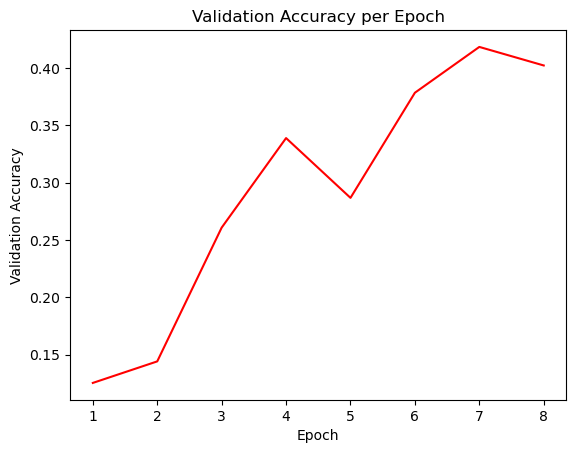

In [ ]:
dic2 = {'Validation Accuracy':val_accuracy_list, 'Epoch':epoch_list}
df2 = pd.DataFrame(data=dic2)

p2 = sns.lineplot(data=df2, x='Epoch', y='Validation Accuracy', color='red')
p2.set_title('Validation Accuracy per Epoch')

plot_title = 'val_acc_per_epoch'

plot_filename = f"trials/{trial_name}/plots/{plot_title}.png"
os.makedirs(os.path.dirname(plot_filename), exist_ok=True)

p2.figure.savefig(plot_filename)
plt.close


In [ ]:
val_loss_list_tensor = [float(x) for x in val_loss_list]
print(val_loss_list_tensor)

dic3 = {'Validation Loss':val_loss_list_tensor, 'Epoch':epoch_list}
df3 = pd.DataFrame(data=dic3)

p3 = sns.lineplot(data=df3, x='Epoch', y='Validation Loss', color='red')
p3.set_title('Validation Loss per Epoch')


plot_title = 'val_loss_per_epoch'

plot_filename = f"trials/{trial_name}/plots/{plot_title}.png"
os.makedirs(os.path.dirname(plot_filename), exist_ok=True)

p3.figure.savefig(plot_filename)
plt.close()

[2.2323758602142334, 2.2070624828338623, 2.055586814880371, 2.0801358222961426, 2.484445571899414, 1.749854326248169, 1.6774739027023315, 1.892346739768982]


<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

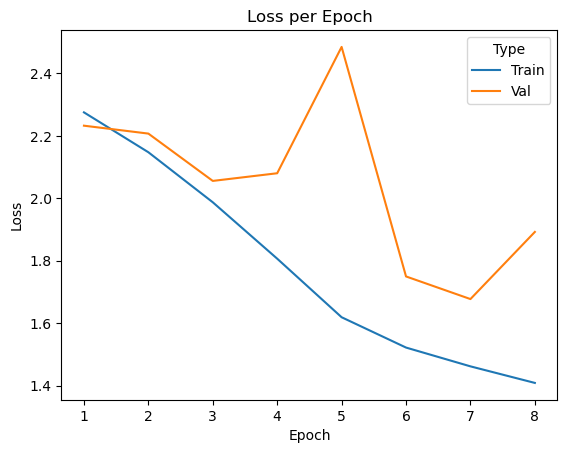

In [ ]:

val_loss_list_tensor = [float(x) for x in val_loss_list]

dic3 = {'Loss':val_loss_list_tensor, 'Epoch':epoch_list}
dic3_df = pd.DataFrame(data=dic3)
dic3_df['Type'] = 'Val'

dic = {'Loss':loss_list, 'epoch':epoch_list}
dic_df = pd.DataFrame(data=dic)
dic_df['Type'] = 'Train'

combined_df = pd.concat([dic_df,dic3_df])

p = sns.lineplot(data=combined_df, x='Epoch', y='Loss', hue='Type')
p.set_title('Loss per Epoch')


plot_title = 'loss_per_epoch'

plot_filename = f"trials/{trial_name}/plots/{plot_title}.png"
os.makedirs(os.path.dirname(plot_filename), exist_ok=True)

p.figure.savefig(plot_filename)
plt.close


In [ ]:
test_single_image = False

if (test_single_image):
    data_iter = iter(testset)

    for i in range(40):
        (data, label) = next(data_iter)
    im = data
    data = data.unsqueeze(0)
    soft = nn.Softmax(dim=1)
    imshow(im)
    print(label)

    model_output = model(data)
    prediction = soft(model_output)

    _, ind = (torch.max(prediction, dim=1))
    print(ind)
    print("\n")

#from torchviz import make_dot, make_dot_from_trace
#make_dot(model_output.mean(), params=dict(model.named_parameters()))




In [ ]:

test_accuracy = calculate_accuracy(model, testloader, device)
kpi_filename = f"trials/{trial_name}/kpi.txt"
os.makedirs(os.path.dirname(kpi_filename), exist_ok=True)

with open(kpi_filename, "w") as f:
    f.write(f"Test Accuracy: {test_accuracy}")

#print(test_accuracy)



0.402


### Code to save Model

In [ ]:
#torch.save(model.state_dict(), "model_weights_130_epochs")